Подготовка датасета

In [ ]:
import zipfile
from google.colab import drive

drive.mount('/content/drive')
zip_data = zipfile.ZipFile('/content/drive/MyDrive/data.zip')
zip_data.extractall()

Mounted at /content/drive


Импорт модулей

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from random import randint
import keras
import tensorflow as tf
from keras import metrics, losses
from keras.models import Model
from keras.layers import (Input, Conv2D, BatchNormalization, Activation,
                          MaxPooling2D, UpSampling2D, Concatenate)

Создание генератора батчей

In [ ]:
def keras_generator(data = 'train', batch_size=16):
  while True:
    x_batch = []
    y_batch = []
    for i in range(batch_size):
      number = randint(51, 550) if data == 'train' else randint(551, 1050)
      if data == 'test':
        number = randint(1, 50)
      img = cv2.imread(f'images/img{number}.png')

      mask = cv2.imread(f'masks/mask{number}.png')

      gray_r = cv2.threshold(mask[:,:,0], 127, 255, cv2.THRESH_BINARY)[1]
      gray_g = cv2.threshold(mask[:,:,1], 127, 255, cv2.THRESH_BINARY)[1]
      gray_b = cv2.threshold(mask[:,:,2], 127, 255, cv2.THRESH_BINARY)[1]

      # Объединяем полученные маски в одну
      gray = cv2.merge([gray_r, gray_g, gray_b])
      gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
      mask = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)[1]

      img = cv2.resize(img, (256, 256))
      mask = cv2.resize(mask, (256, 256))

      x_batch += [img]
      y_batch += [mask]

    x_batch = np.array(x_batch) / 255.
    y_batch = np.array(y_batch) / 255.

    yield x_batch, y_batch

Определение слоев нейросети

In [ ]:
def conv_block(input_tensor, num_filters):
  encoder = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = BatchNormalization()(encoder)
  encoder = Activation('relu')(encoder)
  encoder = Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = BatchNormalization()(encoder)
  encoder = Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = MaxPooling2D(2)(encoder)

  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = UpSampling2D(2, interpolation='bilinear')(input_tensor)
  decoder = Concatenate()([decoder, concat_tensor])
  decoder = BatchNormalization()(decoder)
  decoder = Activation('relu')(decoder)
  decoder = Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder  =BatchNormalization()(decoder)
  decoder = Activation('relu')(decoder)
  decoder = Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = BatchNormalization()(decoder)
  decoder = Activation('relu')(decoder)
  return decoder

In [ ]:
input_model = Input(shape=(256,256,3))

encoder0_pool, encoder0 = encoder_block(input_model, 32)

encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)

encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)

encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)

center = conv_block(encoder3_pool, 512)

decoder3 = decoder_block(center, encoder3, 256)

decoder2 = decoder_block(decoder3, encoder2, 128)

decoder1 = decoder_block(decoder2, encoder1, 64)

decoder0 = decoder_block(decoder1, encoder0, 32)

output_model = Conv2D(1, (3, 3), padding='same')(decoder0)
output_model = Activation('sigmoid')(output_model)

model = Model(inputs=input_model, outputs=output_model)

NameError: ignored

Определение функции потерь

In [ ]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

Определение лучших весов модели

In [ ]:
best_w = keras.callbacks.ModelCheckpoint('unet_best.h5',
                                         monitor='val_loss',
                                         verbose=0,
                                         save_best_only=True,
                                         save_weights_only=True,
                                         model='auto',
                                         period=1)

last_w = keras.callbacks.ModelCheckpoint('unet_best.h5',
                                         monitor='val_loss',
                                         verbose=0,
                                         save_best_only=False,
                                         save_weights_only=True,
                                         model='auto',
                                         period=1)

callbacks = [best_w, last_w]

adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

sgd = keras.optimizers.SGD(lr=0.001, momentum=0.99)

rms = keras.optimizers.RMSprop(lr=0.0002)

model.compile(optimizer=adam, loss='binary_crossentropy',
              metrics=[dice_loss, 'accuracy'])

Обучение модели

In [ ]:
batch_size = 4
model.fit(keras_generator('train', batch_size),
                    steps_per_epoch=10,
                    epochs=50,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=keras_generator('val', batch_size),
                    validation_steps=10,
                    class_weight=None,
                    max_queue_size=10,
                    workers=1,
                    use_multiprocessing=False,
                    shuffle=True,
                    initial_epoch=0)

NameError: ignored

In [ ]:
import shutil

model.save('thermal_control_3.h5')
shutil.move('thermal_control_3.h5', 'drive/MyDrive/')

'drive/MyDrive/thermal_control_3.h5'

Загрузка модели

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/thermal_control_3.h5',
                                custom_objects={"dice_loss": dice_loss})

Тестирование модели

In [ ]:
for x, y in keras_generator('test', 50):
  break


pred = model.predict(x)
eval = model.evaluate(x, y)

2/2 [==============================] - 38s 13s/step - loss: 0.0164 - dice_loss: 0.1095 - accuracy: 0.9927


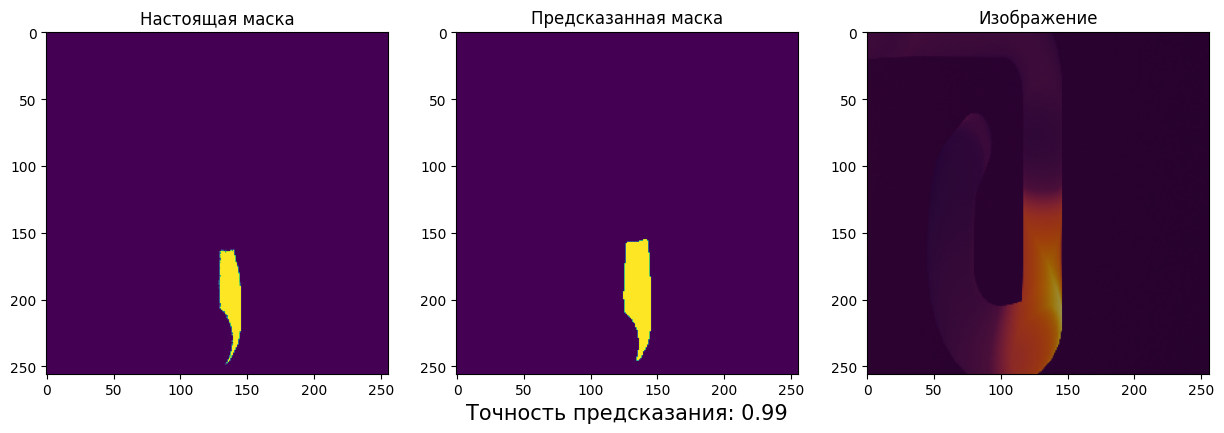

In [ ]:
num = randint(0, 50)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

axes[0].set_title('Настоящая маска')
axes[1].set_title('Предсказанная маска')
axes[1].set_xlabel('Точность предсказания: {:^3.2f}'.format(eval[2]), fontsize=15)
axes[2].set_title('Изображение')

axes[0].imshow(y[num])
axes[1].imshow(pred[num] > 0.5)
axes[2].imshow(x[num][..., [2, 1, 0]])

plt.show()

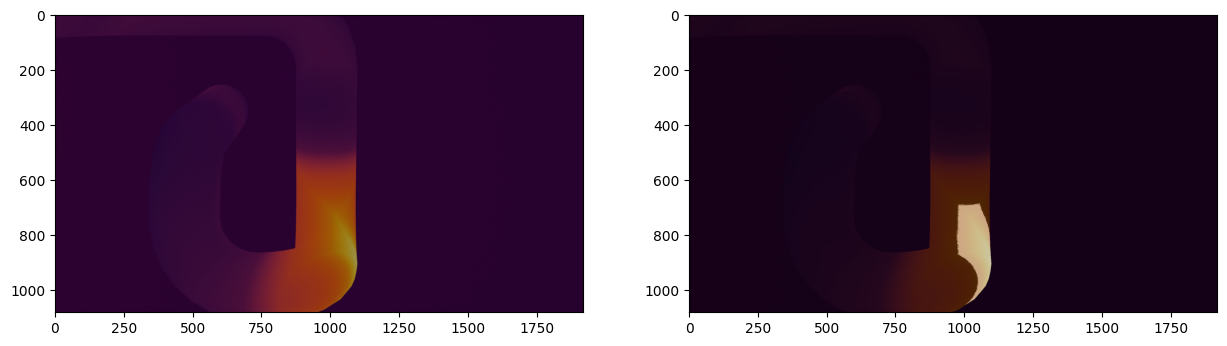

In [ ]:
img1 = cv2.imread(f'images/img4.png')
img2 = cv2.imread(f'masks/mask4.png')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,15))

dst = cv2.addWeighted(img1, 0.5, img2, 0.5, 0)
axes[0].imshow(img1[..., [2, 1, 0]])
axes[1].imshow(dst[..., [2, 1, 0]])

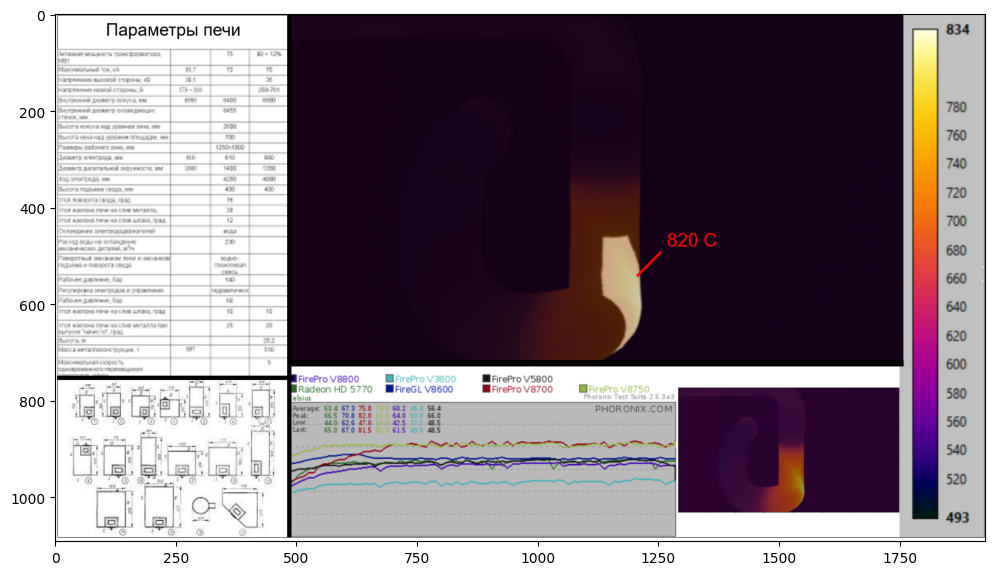

In [ ]:
img = cv2.imread('drive/MyDrive/interface.png')
plt.figure(figsize=(12, 7))
plt.imshow(img[..., [2, 1, 0]])